# Portfolio Optimization using Reverse Quantum Annealing

## Introduction

This chapter presents the utilization of Reverse Quantum Annealing for resolving portfolio optimization issues through the utilization of OpenJij. Reverse Quantum Annealing is an approach that amalgamates classical optimization methodologies with quantum annealing. The chapter is structured in the following manner: We will elaborate on the methods of resolving portfolio optimization problems through classical algorithms, standard quantum annealing, and reverse quantum annealing. Subsequently, we contrast the outcomes obtained from these techniques. Throughout the chapter, we will describe the implementation of quantum annealing via OpenJij and accentuate any potential limitations or caveats of the numerical experiments.

*Note: Note: Execution of this content requires OpenJij version 0.4.9 or higher. If necessary, please execute the following command to update OpenJij prior to proceeding with this notebook.*

```bash
pip install -U openjij
```

## Portfolio Optimization

  In the realm of asset management, investors strive to achieve substantial returns while minimizing risk as much as feasible. 
  Consequently, a prevalent approach is to construct a diversified investment portfolio by integrating assets with moderate returns but minimal (or no) risk and assets with substantial expected returns but also substantial risk.  

  In this scenario, an optimal portfolio must be chosen in order to achieve the maximal profit for a given level of risk or to minimize the risk while obtaining the same profit.
  One of the most widely utilized methodologies currently is the Modern Portfolio Theory proposed by Markowitz.
  This method takes into account the interdependencies among the stocks comprising the portfolio and aims to minimize their covariance [1].

  $$
  \min \sum_{i=1}^{N}\sum_{j=1}^{N}w_{i}w_{j}\sigma_{ij}; \quad \sum_{i=1}^{N}W_{i}=1; \quad \sum_{i=1}^{N}W_{i}\mu_{i}=R
  $$

  $W_i, \sigma_{ij}, \mu_i$, and $R$ denote the weight of each stock in the portfolio, the covariance among the stocks, the expected return of each stock, and the total return of the portfolio, respectively.

  Here, the Sharpe ratio is a widely-utilized metric for assessing the performance of a portfolio.

  ### Sharpe Ratio

  The Sharpe ratio, proposed by William Sharpe in 1966 [3], is a metric for evaluating the efficiency of an investment, applied to both individual stocks and portfolios. It is defined as follows

  $$
  S = \frac{\bar{r}-r_0}{\sigma}
  $$

  Here, $\bar{r}$ represents the average rate of return over a specified time period, typically calculated using the mean of monthly or annual returns. 
  $r_0$ is the rate of return in the risk-free context, usually represented by the interest rate of a stable government bond. 
  $\sigma$ denotes volatility, which is the degree of fluctuation in asset values.   

  The calculation of the Sharpe ratio varies depending on the situation, and the methodologies for determining return and volatility may include using simple returns calculated from asset price $P$ as $r=P(t+1)/P(t) - 1$, or log returns calculated as $r=log[P(t+1)/P(t)]$. 
  Also volatility can be determined from price changes or from the rate of return. 
  For a more comprehensive examination of these methodologies, please refer to literature and resources about financial engineering and market analysis.

  ### Portfolio Evaluation and Optimization

  As per the definition of the Sharpe ratio, a high value connotes high returns or low risk (volatility). 
  Among portfolios constructed from a given set of stocks, the combination that attains the highest Sharpe ratio can be considered as the combination that yields the highest returns per a unit of risk. 
  Thus, the problem of portfolio optimization can be rephrased as the problem of maximizing the Sharpe ratio under a given constraint.  

  In practice, this optimization process involves identifying stocks and determining the proportion of investment allocated to each stock. 
  In other words, it is a combinatorial optimization problem that involves determining the selection of stocks and the weight assigned to each stock. 
  For simplicity, this tutorial will adopt a strategy in which each stock is assigned an equal weight, as per the referenced paper [2]. 
  We select $N$ stocks out of a total of $M$ stocks and find the combination that maximizes the Sharpe ratio. 
  Then, the problem can be formulated into the QUBO form as follows.

  $$
  \mathcal{O}(\boldsymbol{q})=\sum_{i=1}^{N}a_{i}q_{i}+\sum_{i=1}^{N}\sum_{j=i+1}^{N}b_{ij}q_{i}q_{j}
  $$

  Here, $q_{i}$ is a binary variable that denotes the selection of each stock, where a value of $1$ indicates inclusion in the portfolio and a value of $0$ indicates non-inclusion. 
  $a_i$ is the score of attractiveness, derived from the performance of the individual stock, and $b_{ij}$ represents the fines or bonuses as determined by the pairwise correlation between stocks.  

  The specific values of $A_i$ and $B_{ij}$ are established in accordance with the Table 1 below.

  <img src="../../../assets/reverse_annealing_RQA_QUBO.png">

  The $a_i$ groups in this table are criteria established by the portfolio's creators, with stocks ordered by their attractiveness.
  The table displays the groups formed when they are ranked and divided equally. 
  The attractiveness criterion can also incorporate factors such as a high rate of return, but for this tutorial, we simply use the order of individual stocks based on the Sharpe ratio. 
  $B_{ij}$ is determined by the value of the component $\rho_{ij}$ of the correlation matrix obtained from the time series of log returns.  

  By performing quantum annealing using this QUBO, we should be able to obtain the optimal portfolio. 
  If multiple stocks are selected, a constraint on the number of stocks can be added. 
  However, as described in the referenced paper [2], when constraints are added to the QUBO using this method, the large interaction (penalty) introduced can also affect the annealing performance and the final results obtained. 
  In a real-world scenario, the number of stocks in the optimal portfolio is unknown, thus, this tutorial performs the same optimization without any restriction on the number of stocks.

## Portfolio Optimization with Reverse Quantum Annealing

The problem of portfolio optimization in the real world is to select a subset of stocks from a market with a vast array of options. 
Additionally, due to the huge number of possible stock combinations, it is likely that there exist numerous local minima, which correspond portfolios with Sharpe ratios that are quite close to the maximum. 
Conventional algorithms, when trapped in the trough of such an energy landscape, need a significant amount of time and resources to escape. 
To circumvent the above issue and solve portfolio optimization problems more efficiently, computational methods such as quantum annealing, which can handle a large number of correlations and are less prone to getting trapped in local minima, are more effective.  

However, as demonstrated in the reference paper [2], when only simple forward annealing is used, the time required to reach the optimal solution increases dramatically as the number of issues increases. 
This is because the difference in energy between the optimal solution and local minima with a Sharpe ratio close to the optimal solution is small. 
Due to a high potential barrier between these levels with almost no energy change, transition from local minima to optimal require a longer time.
Furthermore, in actual quantum annealing machines, the system may be excited by thermal noise or other factors during standard annealing, resulting in a deviation from the intended time evolution and a final solution that is not truly optimal obtained.

### Reverse Quantum Annealing

One of the proposed methods for addressing the challenges associated with using quantum annealing in portfolio optimization is reverse quantum annealing. 
As the name implies, this approach involves conducting quantum annealing in a manner that incorporates a step in the opposite direction of conventional forward annealing. 
The time-dependent Hamiltonian of standard forward annealing is represented as

$$
\mathcal{H}_{\mathrm{QA}}(t)=A[t]\sum_{i=1}^N\sigma_{i}^{\mathrm{x}}+B[t]\mathcal{H}_{\chi-\mathrm{Ising}}
$$

where $A[t]$ is the magnitude of the transverse magnetic field applied to the system during annealing, and $B[t]$ represents the amplitude of the problem Hamiltonian $\mathcal{H}_{\chi-\mathrm{Ising}}$, respectively. 
As depicted in the following figure a), in the case of forward annealing, $A[t]$ is gradually decreased as the annealing progresses, and concurrently, $B[t]$ is made dominant.
At the completion of annealing, $A[t] = 0$.

<img src="../../../assets/reverse_annealing_QAandRQA.png">

In contrast, reverse annealing starts from $A[t]=0, B[t]=1$, as depicted in Figure b).
In this method, $B[t]$ is initially decreased, in contrast to the standard annealing.
This is referred to as the reverse phase.
In this phase, the system's energy is inversely increased, making it easier to tunnel the potential barrier between A and B, as illustrated in c).
After $A[t]$ and $B[t]$ reach a specific value, the system is kept in the same state and allowed to wait for a while. 
This is referred to as the pause phase.
During this phase, a high energy state is maintained, increasing the likelihood of thermal hopping. 
The potential barrier on the right side of B is also easily overcome.
This suggests that the possibility of escaping from the initial local minimum and reaching a near-optimal solution is increased. 
Finally, the optimal solution is attained by conducting standard annealing in the forward phase, which once again makes $A[t]$ smaller and $B[t]$ larger.
In this protocol, the performance of the final solution may also be impacted by the value at which $A[t], B[t]$ is stopped in the reverse phase, the duration of each phase, etc.

### Portfolio Optimization Procedure with Reverse Quantum Annealing

From the previous discussion, reverse annealing requires a reverse phase initial state.
While it can be used randomly generated initial states, it is predicted that the efficacy of the optimal solution search will be enhanced when a specific local minumu state is implemented.
The reference paper [2] employs the output generated by a conventional algorithm.
This tutorial will follow the method outlined in the reference paper [2], which entails the following steps. 

* Generation of data for stocks to be optimizaed
* Implementation of a classical algorithm and examination of its results
* Search for an optimal solution through standard forward annealing
* Search for an optimal solution through reverse quantum annealing
* Exploration of parameters for reverse quantum annealing

## Generation of stock data and implementation of classical algorithms

### Generation of stock data to be optimized

We generate a chart of stocks by Brownian motion using the given initial values according to the method in reference paper [2].

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Magic numbers to generate assets
rho = 0.1 # input uniform correlation
mu = 0.075 # expected value
sigma = 0.15 # volatility/standard error
r0 = 0.015 # no risk return

The motion of the chart at each time, as outlined in Appendix A of reference paper [2], is derived from the motion at the preceding time, as follows:

$$
S(t_{n+1})=S(t_n)\exp(\mu-\frac{1}{2}\sigma^2)\Delta t + \sigma Z_n\sqrt{\Delta t}
$$

where $Z_n$ is the multivariate normal distribution following the uniform correlation matrix ρ, constructed via the Cholesky decomposition.  

We shall now implement and run this equation, and plot the chart to observe its appearance. 
By beginning with the same initial value and examining the 12-month trend, we can discern the overall behavior to spread out.
Additionally, we can observe certain stocks note any significant increases or decreases.

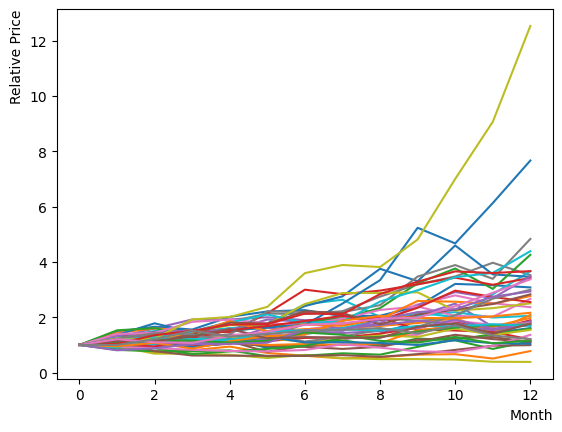

In [2]:
# generate correlated normal probability variables, Zn
def createZvariables(N, rho):
  rho_mat = np.full((N,N), rho)
  rho_mat[range(N), range(N)] = 1.0
  rho_chole = np.linalg.cholesky(rho_mat)
  zNs_temp = np.random.normal(0, 1, (10000, N))
  zNs = zNs_temp @ rho_chole
  return zNs

# generate Brownian motion of the chart
def GetNextSt(St, mu, sigma, zN):
  Deltat = 1
  scale = np.exp((mu-0.5*sigma*sigma)*Deltat + sigma*zN*np.sqrt(Deltat))
  NextSt = St * scale
  return NextSt

Nassets = 48 # the number of stocks
chart = list()
ZList = list()
Zvariables = createZvariables(Nassets, rho)
Zlabels = random.sample([x for x in range(10000)], 12) #Z variable shuffle

for label in Zlabels:
  ZList.append(Zvariables[label])

for iasset in range(Nassets):
  chart_asset = [1.0] # initial value: 1.0 at relative price

  # simulate 12 steps (12 months)
  for month in range(12):
    chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))

  chart.append(chart_asset)
  #print(chart_asset) # display specific values for each stocks
  plt.plot(list(range(13)), chart_asset)

plt.xlabel("Month", loc="right")
plt.ylabel("Relative Price", loc="top")
plt.show()
